## Language Identification from Speech


OBJECTIVE:    Develop a NN to find identify the language (English/Hindi) used in the SPEECH.

SPEECH:
1. To get SPEECH files (audio files) use any TEXT to SPEECH converter.
2. For this project-> https://www.indiadict.com/web/text-to-speech.html 
3. This website allows to generate English and Hindi speech from English Text.
4. The speech files are in mp3 format.

PROCESSING OF SPEECH:
1. Speech is an audio signal.
2. To process audio signals use LIBROSA library. https://librosa.github.io/librosa/
3. If the downloaded files are in mp3 fomat->  pip install audioread

FEATURE COLLECTION:
1. Audio Signal-> Features-> Neural Network-> TRAIN
2. To get feature LIBROSA library willbe very usefull.
3. For analysis we find-> "mfccs,chroma,mel,spectral contrast,tonnetz" FEATURES.

SAMPLING:
1. https://en.wikipedia.org/wiki/Sampling_(signal_processing)

MFCCS-> Mel Frequency Cepstral Coefficient
1. https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
2. https://nlp.stanford.edu/courses/lsa352/lsa352.lec6.ppt

    Pre-emphasis
    1. https://www.quora.com/Why-is-pre-emphasis-i-e-passing-the-speech-signal-through-a-first-order-high-pass-filter-required-in-speech-processing-and-how-does-it-work
    2. https://www.daenotes.com/electronics/communication-system/pre-emphasis-and-de-emphasis

    Windowing
    1. https://www.youtube.com/watch?v=RJ4ZU_SOH7I
    2. https://www.youtube.com/watch?v=aVA_mUiRyHc
    3. http://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

    Fourier Tranform
    1. https://www.youtube.com/watch?v=b-JxoHKv27Y&t=595s
    2. https://www.youtube.com/watch?v=BXghmsH-mKY&t=484s
    3. https://www.youtube.com/watch?v=dCeHOf4cJE0

    Mel Filter
    1. https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
    2. https://dsp.stackexchange.com/questions/19574/mel-filter-in-mfcc-is-it-necessary

CHROMA Feature
1. https://en.wikipedia.org/wiki/Chromatic_scale
2. https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/

SPECTRAL CONTRAST Feature
1. http://docs.twoears.eu/en/latest/afe/available-processors/spectral-features/




In [116]:
import os
import pandas as pd
import librosa
import glob 
import matplotlib.pyplot as plt
import librosa.display
import numpy as np


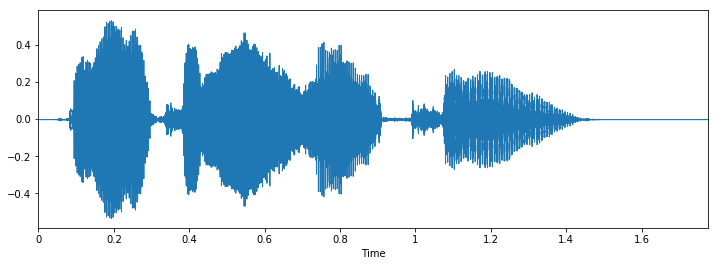

In [118]:
data, sampling_rate = librosa.load('F:/4 year/NLP/project/file/test/eng/bro can I help you.mp3')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

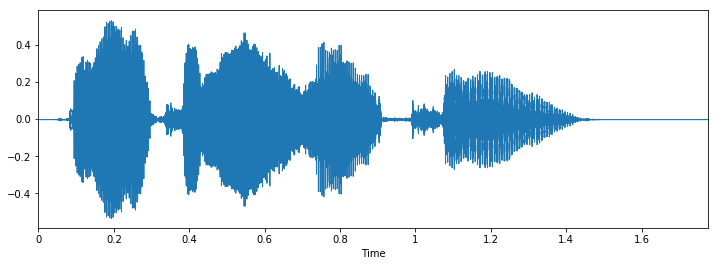

In [119]:
data, sampling_rate = librosa.load('F:/4 year/NLP/project/file/test/eng/bro can I help you.mp3')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)




In [120]:
def extract_feature(file_name):
    
    X, sample_rate = librosa.load(file_name)
    
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    
    #print(file_name + str(mfccs.shape) + str(chroma.shape) + str(mel.shape) + str(contrast.shape) + str(tonnetz.shape))
    #in total we get 193 features-> Therefore the size of Numpy array is 193
    
    return mfccs,chroma,mel,contrast,tonnetz

# finding all the files in a folder with extension .mp3
# sub_dir will has all the audio files
# parent_dir will have folders for different language audio files 
def parse_audio_files(parent_dir,sub_dirs,file_ext="*.mp3"):
    
    
    features, labels = np.empty((0,193)), np.empty(0)
    
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            
            
            try:
              mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
              print ("Error encountered while parsing file: ", fn)
              continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            
            if sub_dir=='hindi':
                labels = np.append(labels, 0)
            elif sub_dir=='eng':
                labels = np.append(labels, 1)            
                            
    return np.array(features) , np.array(labels, dtype = np.int)




In [121]:
parent_dir = 'F:/4 year/NLP/project/file/train'
tr_sub_dirs = ["hindi","eng"]

test_parent_dir = 'F:/4 year/NLP/project/file/test'
test_sub_dirs = ["hindi", "eng"]



tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)

tst_features, tst_labels = parse_audio_files(test_parent_dir,test_sub_dirs)


#print(tr_features.shape,tr_labels.shape)
print(tr_labels)


for i,data in enumerate(tr_features):
    print(i)
    print("-------------")
    print(data)


[0 0 0 0 0 0 1 1 1 1 1 1]
0
-------------
[-2.62273015e+02  1.35077874e+02 -7.08939617e+01  4.54595726e+01
 -1.01618946e+01 -8.95454247e+00  9.27526676e+00 -1.26280563e+01
 -1.17841322e+01  1.54300466e+00 -1.05705409e+01  8.73648762e+00
 -2.16515273e+01 -2.45804694e+00  7.79522323e+00 -1.46634524e+01
  9.79909640e-01 -2.58234010e+00 -1.65547221e+00 -8.57444577e+00
  1.88967194e+00 -6.81573330e+00 -3.16239096e+00  1.77653472e+00
  2.32827959e+00  6.06711522e+00  5.08899643e+00  3.83279099e+00
  2.25068949e+00  3.68635703e+00  3.38819876e+00  4.85506551e+00
 -3.33565562e+00  2.52256976e+00 -1.36131902e+00  1.33456239e+00
  5.00340795e+00  2.81506342e+00  9.94547178e-01 -9.68073933e-01
  5.31810502e-01  5.42326092e-01  5.28039082e-01  5.33402485e-01
  5.85850501e-01  6.24779590e-01  6.30424011e-01  5.99913891e-01
  5.03658904e-01  5.20352709e-01  5.20747187e-01  4.82079399e-01
  4.34668520e-01  4.05163350e-02  2.35105153e-02  1.86527023e-02
  7.52499414e-01  3.52537832e+00  1.12570457e+01

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [123]:
# model from http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(193, 280)
        self.l2 = nn.Linear(280, 300)
        self.l3 = nn.Linear(300, 1)
        self.tan =nn.Tanh()
        self.sigmoid=nn.Sigmoid()

    def forward(self, x):
        #x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = self.tan(self.l1(x))
        x = self.tan(self.l2(x))
        x = self.sigmoid(self.l3(x))
        return x


model = Net()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

tr_features = Variable ( torch.FloatTensor(tr_features) )
tr_labels1 = Variable ( torch.FloatTensor(tr_labels) )

tst_features = Variable ( torch.FloatTensor(tst_features) )
tst_labels1 = Variable ( torch.FloatTensor(tst_labels) )



def train(epoch):
    
    for i,data in enumerate(tr_features):
        
        targetTnsr=tr_labels1[i]
        targetTnsr=torch.tensor([targetTnsr])
           
    
        #target = torch.from_numpy(target)
        
        data, targetTnsr = Variable(data), Variable(targetTnsr)
    
        optimizer.zero_grad()
        output = model(data)
        print("Output "+str(output))
        print("Target "+str(targetTnsr))
        loss = criterion(output, targetTnsr)
        print(loss)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))

def test():

    test_loss = 0
    correct = 0
    for i,data in enumerate(tst_features):
        targetTnsr=tst_labels1[i]
        targetTnsr=torch.tensor([targetTnsr])
       
        data, targetTnsr = Variable(data), Variable(targetTnsr)
        optimizer.zero_grad()
        output = model(data)
        
        # sum up batch loss
        loss = criterion(output, targetTnsr)
        test_loss += loss
        pred = output.data

        if int(pred.data.numpy()[0])==round(tr_labels[i]):
            correct += 1
        
        
       

        print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))
        
        
        
    

    test_loss /= 11
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, 11,
        100. * correct / 11))
    return (correct / 11)



acc=[]
npacc=np.empty(0)
totalEpoch = 100
for epoch in range(1, totalEpoch):
    train(epoch)
    print('\n')
    ac = test()
    acc.append(ac)
    npacc = np.asarray(acc)
    print("------------------")
print(npacc)
print(len(acc))

Output tensor([0.4146], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.5354, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 1 Loss: 0.535424
Output tensor([0.3104], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.3717, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 1 Loss: 0.371664
Output tensor([0.1560], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.1696, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 1 Loss: 0.169565
Output tensor([0.1008], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.1063, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 1 Loss: 0.106296
Output tensor([0.0675], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.0699, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 1 Loss: 0.069933
Output tensor([0.0454], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.0464, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 1 Loss: 0.046434
Output tensor([0.0428], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tenso

Target tensor([0.])
tensor(0.5828, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 7 Loss: 0.582838
Output tensor([0.4064], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.9005, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 7 Loss: 0.900535
Output tensor([0.4128], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.8849, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 7 Loss: 0.884912
Output tensor([0.4378], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.8261, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 7 Loss: 0.826081
Output tensor([0.4686], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7579, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 7 Loss: 0.757932
Output tensor([0.5103], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6728, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 7 Loss: 0.672771
Output tensor([0.5348], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6258, grad_fn=<BinaryCrossEntropyBackward>)
Tra

Train Epoch: 13 Loss: 0.642726
Train Epoch: 13 Loss: 0.644302
Train Epoch: 13 Loss: 0.644380

Test set: Average loss: 0.7543, Accuracy: 6/11 (55%)

------------------
Output tensor([0.5251], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7446, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 14 Loss: 0.744567
Output tensor([0.5240], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7423, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 14 Loss: 0.742308
Output tensor([0.5163], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7264, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 14 Loss: 0.726379
Output tensor([0.5061], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7054, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 14 Loss: 0.705397
Output tensor([0.4845], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6626, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 14 Loss: 0.662584
Output tensor([0.4849], grad_fn=<SigmoidBackward>)
Target 

Output tensor([0.5008], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6946, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 20 Loss: 0.694649
Output tensor([0.4855], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6646, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 20 Loss: 0.664580
Output tensor([0.4816], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6570, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 20 Loss: 0.656975
Output tensor([0.4766], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7411, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 20 Loss: 0.741060
Output tensor([0.4732], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7483, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 20 Loss: 0.748335
Output tensor([0.4834], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7270, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 20 Loss: 0.726959
Output tensor([0.4909], grad_fn=<SigmoidBackward>)
Target tensor([1.])

tensor(0.7103, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 26 Loss: 0.710331
Output tensor([0.4948], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7037, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 26 Loss: 0.703699
Output tensor([0.4992], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6948, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 26 Loss: 0.694753
Output tensor([0.5034], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6863, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 26 Loss: 0.686285


Train Epoch: 26 Loss: 0.711074
Train Epoch: 26 Loss: 0.710942
Train Epoch: 26 Loss: 0.711069
Train Epoch: 26 Loss: 0.710905
Train Epoch: 26 Loss: 0.677837
Train Epoch: 26 Loss: 0.711057
Train Epoch: 26 Loss: 0.675550
Train Epoch: 26 Loss: 0.670807
Train Epoch: 26 Loss: 0.675535
Train Epoch: 26 Loss: 0.675585
Train Epoch: 26 Loss: 0.675505
Train Epoch: 26 Loss: 0.675685

Test set: Average loss: 0.7529, Accuracy: 6/11 (55%)

------------------
Out

Train Epoch: 32 Loss: 0.719554
Train Epoch: 32 Loss: 0.697555
Train Epoch: 32 Loss: 0.719554
Train Epoch: 32 Loss: 0.722571
Train Epoch: 32 Loss: 0.688272
Train Epoch: 32 Loss: 0.719531
Train Epoch: 32 Loss: 0.667252
Train Epoch: 32 Loss: 0.667424
Train Epoch: 32 Loss: 0.667458
Train Epoch: 32 Loss: 0.658918
Train Epoch: 32 Loss: 0.667436
Train Epoch: 32 Loss: 0.666064

Test set: Average loss: 0.7511, Accuracy: 6/11 (55%)

------------------
Output tensor([0.5130], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7196, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 33 Loss: 0.719554
Output tensor([0.5029], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6991, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 33 Loss: 0.699051
Output tensor([0.5089], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7112, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 33 Loss: 0.711173
Output tensor([0.5038], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7009, gra

tensor(0.6914, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 39 Loss: 0.691405
Output tensor([0.5078], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7089, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 39 Loss: 0.708943
Output tensor([0.5026], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6984, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 39 Loss: 0.698350
Output tensor([0.4851], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6638, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 39 Loss: 0.663828
Output tensor([0.4922], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6776, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 39 Loss: 0.677638
Output tensor([0.4868], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7199, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 39 Loss: 0.719949
Output tensor([0.4870], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7194, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 39 L

Target tensor([0.])
tensor(0.6611, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 45 Loss: 0.661090
Output tensor([0.4914], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6760, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 45 Loss: 0.676044
Output tensor([0.4854], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7229, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 45 Loss: 0.722860
Output tensor([0.4858], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7219, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 45 Loss: 0.721935
Output tensor([0.4894], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7146, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 45 Loss: 0.714587
Output tensor([0.4943], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7045, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 45 Loss: 0.704517
Output tensor([0.4998], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6935, grad_fn=<BinaryCrossEntropyBackward

Target tensor([0.])
tensor(0.7110, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 51 Loss: 0.711010
Output tensor([0.5043], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7018, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 51 Loss: 0.701814
Output tensor([0.4859], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6654, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 51 Loss: 0.665383
Output tensor([0.4945], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6822, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 51 Loss: 0.682178
Output tensor([0.4895], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7143, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 51 Loss: 0.714313
Output tensor([0.4901], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7132, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 51 Loss: 0.713216
Output tensor([0.4948], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7037, grad_fn=<BinaryCrossEntropyBackward

Target tensor([1.])
tensor(0.6880, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 56 Loss: 0.687957
Output tensor([0.5072], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6788, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 56 Loss: 0.678847


Train Epoch: 56 Loss: 0.724582
Train Epoch: 56 Loss: 0.695487
Train Epoch: 56 Loss: 0.724483
Train Epoch: 56 Loss: 0.724427
Train Epoch: 56 Loss: 0.688937
Train Epoch: 56 Loss: 0.724475
Train Epoch: 56 Loss: 0.662773
Train Epoch: 56 Loss: 0.662627
Train Epoch: 56 Loss: 0.662783
Train Epoch: 56 Loss: 0.662756
Train Epoch: 56 Loss: 0.662762
Train Epoch: 56 Loss: 0.662819

Test set: Average loss: 0.7508, Accuracy: 6/11 (55%)

------------------
Output tensor([0.5155], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7246, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 57 Loss: 0.724582
Output tensor([0.5009], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6949, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 5

Train Epoch: 62 Loss: 0.667592
Train Epoch: 62 Loss: 0.667638
Train Epoch: 62 Loss: 0.667702

Test set: Average loss: 0.7504, Accuracy: 6/11 (55%)

------------------
Output tensor([0.5130], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7195, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 63 Loss: 0.719472
Output tensor([0.4981], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6894, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 63 Loss: 0.689421
Output tensor([0.5094], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7121, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 63 Loss: 0.712105
Output tensor([0.5042], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7017, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 63 Loss: 0.701672
Output tensor([0.4853], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6641, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 63 Loss: 0.664082
Output tensor([0.4942], grad_fn=<SigmoidBackward>)
Target 

Target tensor([0.])
tensor(0.7136, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 69 Loss: 0.713557
Output tensor([0.5053], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7038, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 69 Loss: 0.703801
Output tensor([0.4853], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6641, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 69 Loss: 0.664101
Output tensor([0.4950], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6832, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 69 Loss: 0.683206
Output tensor([0.4896], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7142, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 69 Loss: 0.714238
Output tensor([0.4899], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7136, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 69 Loss: 0.713587
Output tensor([0.4929], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7074, grad_fn=<BinaryCrossEntropyBackward

Output tensor([0.5080], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6772, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 73 Loss: 0.677179


Train Epoch: 73 Loss: 0.721670
Train Epoch: 73 Loss: 0.690286
Train Epoch: 73 Loss: 0.721544
Train Epoch: 73 Loss: 0.721531
Train Epoch: 73 Loss: 0.683529
Train Epoch: 73 Loss: 0.721528
Train Epoch: 73 Loss: 0.665551
Train Epoch: 73 Loss: 0.665266
Train Epoch: 73 Loss: 0.665558
Train Epoch: 73 Loss: 0.665369
Train Epoch: 73 Loss: 0.665530
Train Epoch: 73 Loss: 0.665596

Test set: Average loss: 0.7503, Accuracy: 6/11 (55%)

------------------
Output tensor([0.5141], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7217, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 74 Loss: 0.721670
Output tensor([0.4984], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6900, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 74 Loss: 0.690045
Output tensor([0.5104], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7141, g

Target tensor([0.])
tensor(0.7230, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 80 Loss: 0.723018
Output tensor([0.4985], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6902, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 80 Loss: 0.690181
Output tensor([0.5109], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7152, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 80 Loss: 0.715226
Output tensor([0.5060], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7052, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 80 Loss: 0.705240
Output tensor([0.4849], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6634, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 80 Loss: 0.663433
Output tensor([0.4955], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6842, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 80 Loss: 0.684161
Output tensor([0.4899], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7135, grad_fn=<BinaryCrossEntropyBackward

Target tensor([1.])
tensor(0.7126, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 86 Loss: 0.712622
Output tensor([0.4934], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7064, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 86 Loss: 0.706368
Output tensor([0.4981], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6969, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 86 Loss: 0.696934
Output tensor([0.5033], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6866, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 86 Loss: 0.686611
Output tensor([0.5088], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6757, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 86 Loss: 0.675737


Train Epoch: 86 Loss: 0.724470
Train Epoch: 86 Loss: 0.689782
Train Epoch: 86 Loss: 0.723584
Train Epoch: 86 Loss: 0.723379
Train Epoch: 86 Loss: 0.683641
Train Epoch: 86 Loss: 0.723541
Train Epoch: 86 Loss: 0.663654
Train Epoch: 86 Loss: 0.661584
Train Epoch: 86 Loss: 0.66

Train Epoch: 92 Loss: 0.661313
Train Epoch: 92 Loss: 0.662665
Train Epoch: 92 Loss: 0.662748

Test set: Average loss: 0.7495, Accuracy: 6/11 (55%)

------------------
Output tensor([0.5155], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7246, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 93 Loss: 0.724621
Output tensor([0.4982], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6895, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 93 Loss: 0.689486
Output tensor([0.5117], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7167, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 93 Loss: 0.716737
Output tensor([0.5065], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.7062, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 93 Loss: 0.706220
Output tensor([0.4843], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6622, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 93 Loss: 0.662244
Output tensor([0.4957], grad_fn=<SigmoidBackward>)
Target 

Output tensor([0.4949], grad_fn=<SigmoidBackward>)
Target tensor([0.])
tensor(0.6830, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 99 Loss: 0.682967
Output tensor([0.4907], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7119, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 99 Loss: 0.711894
Output tensor([0.4910], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7114, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 99 Loss: 0.711402
Output tensor([0.4932], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.7069, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 99 Loss: 0.706860
Output tensor([0.4968], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6996, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 99 Loss: 0.699611
Output tensor([0.5000], grad_fn=<SigmoidBackward>)
Target tensor([1.])
tensor(0.6932, grad_fn=<BinaryCrossEntropyBackward>)
Train Epoch: 99 Loss: 0.693212
Output tensor([0.5037], grad_fn=<SigmoidBackward>)
Target tensor([1.])

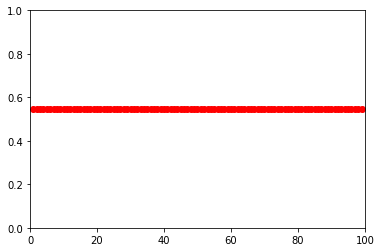

In [124]:
epoc=range(1, totalEpoch)
plt.plot(epoc, acc, 'ro')
plt.axis([0, totalEpoch, 0, 1])
plt.show()